In [2]:
!git clone https://github.com/hossein-omidi/PINN_MPC_CUDA.git

fatal: destination path 'PINN_MPC_CUDA' already exists and is not an empty directory.


In [3]:
import os

# Set the desired directory (replace with your directory path)
desired_directory = '/content/PINN_MPC_CUDA/PINN-MPC14_2'

# Change the current working directory
os.chdir(desired_directory)

# Verify the current working directory
print("Current Directory:", os.getcwd())

Current Directory: /content/PINN_MPC_CUDA/PINN-MPC14_2


PyTorch version: 2.5.1+cu124
CUDA available: True
CUDA version: 12.4
Device count: 1
Current device: 0
Device name: Tesla T4
cuda:0
Epoch [       100/10000], Loss: 183.5222930908
Epoch [       200/10000], Loss: 5.5630073547
Epoch [       300/10000], Loss: 5.4140996933
Epoch [       400/10000], Loss: 5.2656798363
Epoch [       500/10000], Loss: 5.1064052582
Epoch [       600/10000], Loss: 4.9395089149
Epoch [       700/10000], Loss: 4.7670602798
Epoch [       800/10000], Loss: 4.5905008316
Epoch [       900/10000], Loss: 4.4108481407
Epoch [      1000/10000], Loss: 4.2288880348
Epoch [      1100/10000], Loss: 4.0453467369
Epoch [      1200/10000], Loss: 3.8609251976
Epoch [      1300/10000], Loss: 3.6763329506
Epoch [      1400/10000], Loss: 3.4922654629
Epoch [      1500/10000], Loss: 3.3094182014
Epoch [      1600/10000], Loss: 3.1284871101
Epoch [      1700/10000], Loss: 2.9501624107
Epoch [      1800/10000], Loss: 2.7751207352
Epoch [      1900/10000], Loss: 2.6040196419
Epoch [    

/content/PINN_MPC_CUDA/PINN-MPC14_2/plotting.py:57: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


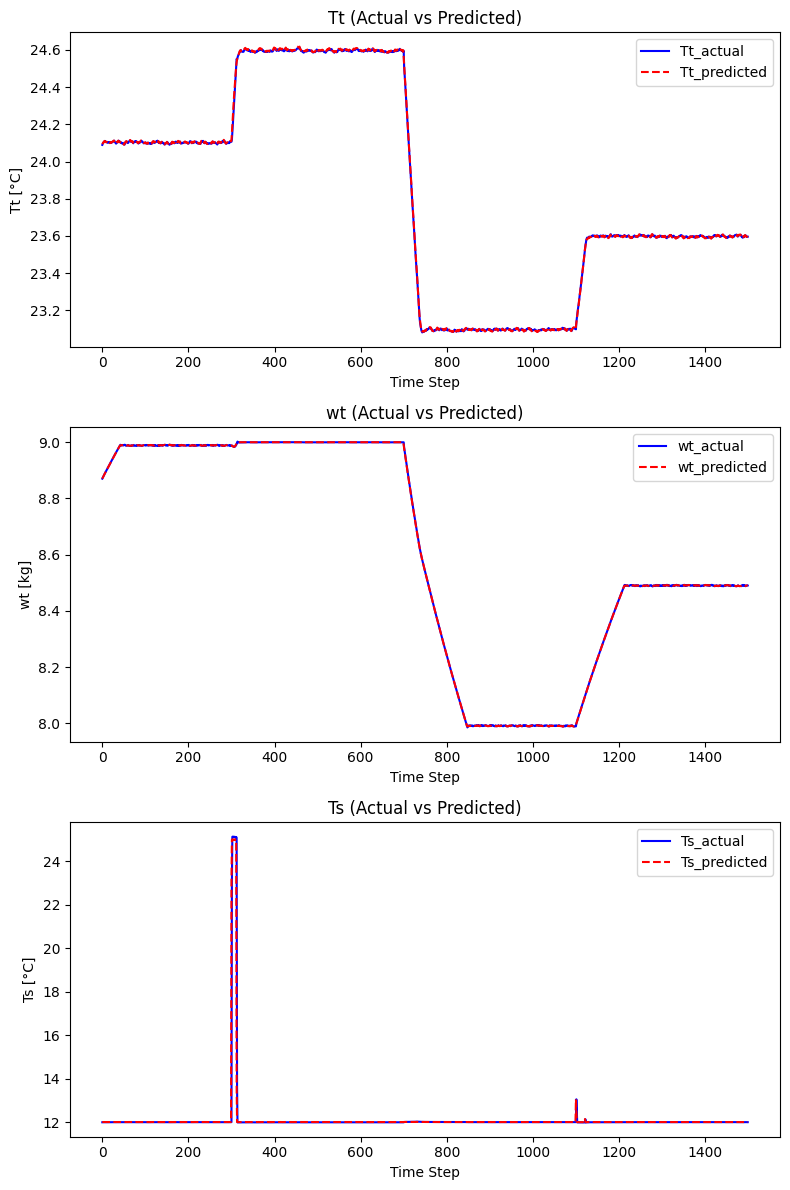

In [4]:
from BldgEnergy import BuildingModel, schedule
from model import get_model, Optimization
from plotting import BldgEnergyPlot, testplot
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
import csv
import os
import matplotlib

from model import get_model, Optimization
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
import pandas as pd
import matplotlib



print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Device count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(0))


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
controls_df = pd.read_csv('mpc_controls.csv')
inputs = controls_df[['MPC fa_dot', 'MPC fw_dot', 'MPC u3']].values
inputs[:, 2] = inputs[:, 2] * 1000  # Multiply 'MPC u3' column by 1000

# Load state outputs
states_df = pd.read_csv('mpc_states.csv')
outputs = states_df[['MPC Tt', 'MPC wt', 'MPC Ts']].values
outputs[:, 1] = outputs[:, 1] * 1000  # Multiply 'MPC wt' column by 1000

# Create sequence data (current state + current input -> next state)
x_array = np.hstack((outputs[:-1], inputs[:-1]))  # Shape: (N-1, 6)
y_array = outputs[1:]                             # Shape: (N-1, 3)

# Train-test split
# Replace with time-series-friendly split:
test_size = 0.3
split_idx = int(len(x_array) * (1 - test_size))
x_train, x_test = x_array[:split_idx], x_array[split_idx:]
y_train, y_test = y_array[:split_idx], y_array[split_idx:]
# Convert to tensors
x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.FloatTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test).to(device)
y_test = torch.FloatTensor(y_test).to(device)

# Model define
mo = 'PINN'
hidden_dim = 256  # Increased capacity for MIMO system
layer_dim = 12  # Deeper network
input_dim = 6      # 3 states + 3 inputs
output_dim = 3     # 3 output states

model_params = {
    'input_dim': input_dim,
    'hidden_dim': hidden_dim,
    'layer_dim': layer_dim,
    'output_dim': output_dim
}
model_name = "lstm"
model = get_model(model_name, model_params)
model = model.to(device)
# optimizer setup
learning_rate = 1e-4
weight_decay = 1e-6
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
opt = Optimization(model=model, mo=mo, optimizer=optimizer)
# training
n_epochs = 10000
opt.train(x_train, y_train, n_epochs)
# Save model
torch.save(model.state_dict(), mo + "_STZ_colab.pth")
# Testing Prediction
yt = model(x_test)
loss_test = torch.mean((yt - y_test) ** 2).detach()  # MSE test
print('MSE of test: {:.10f}'.format(loss_test))

# Model Test Plot
yact = yt.cpu().detach().numpy()  # Convert to numpy
ypred = y_test.cpu().reshape(-1, 3).numpy()  # Ensure ypred is reshaped to (N, 3)

testplot(yact, ypred)





In [7]:
from google.colab import files

# Save the model to Colab's temporary storage
save_path = f"{mo}_STZ_colab.pth"  # Saves to Colab's local temp storage
torch.save(model.state_dict(), save_path)

# Download the file to your computer
files.download(save_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [9]:
import numpy as np
import pandas as pd
import torch
from model import get_model
from MPC import cost_fun_mimo
from plotting import MPCplot
import matplotlib


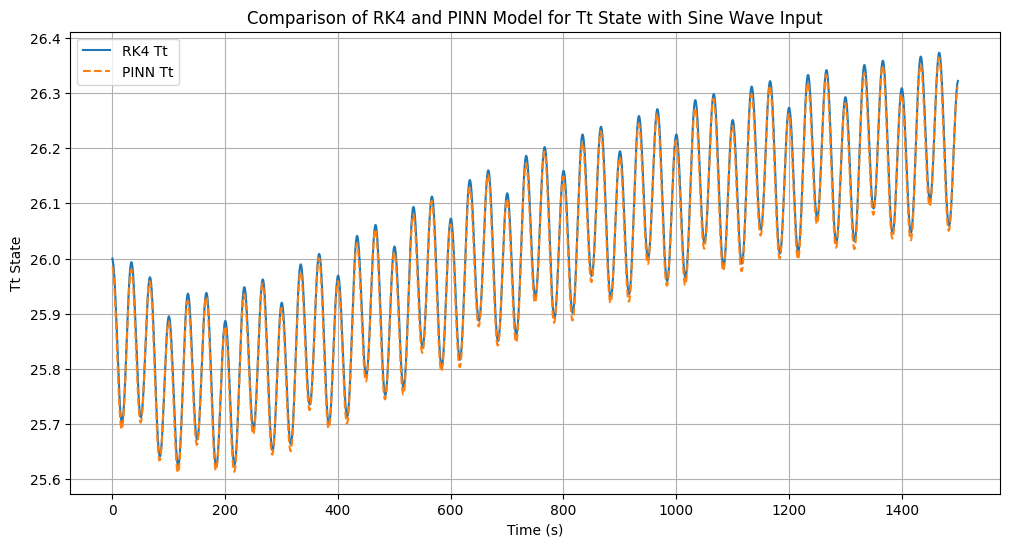

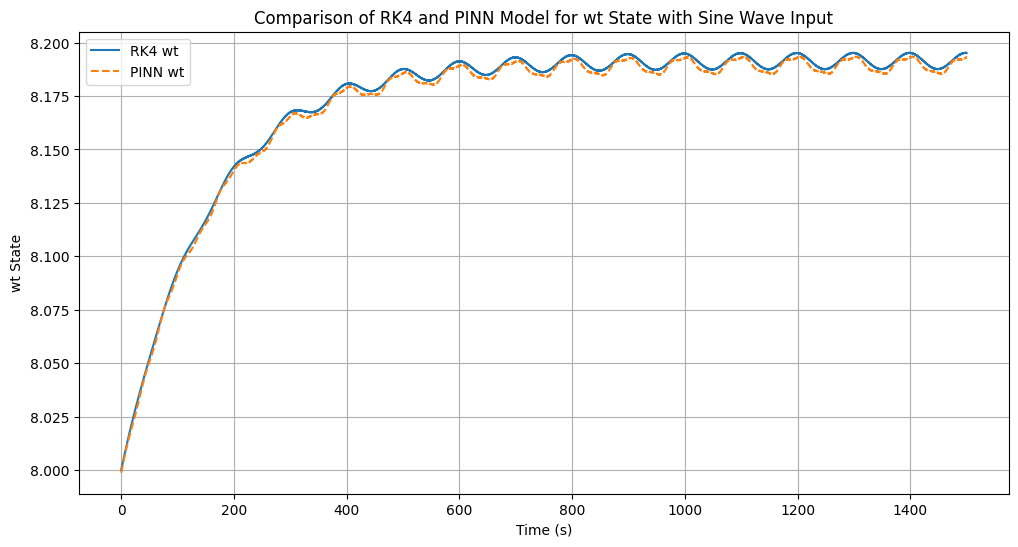

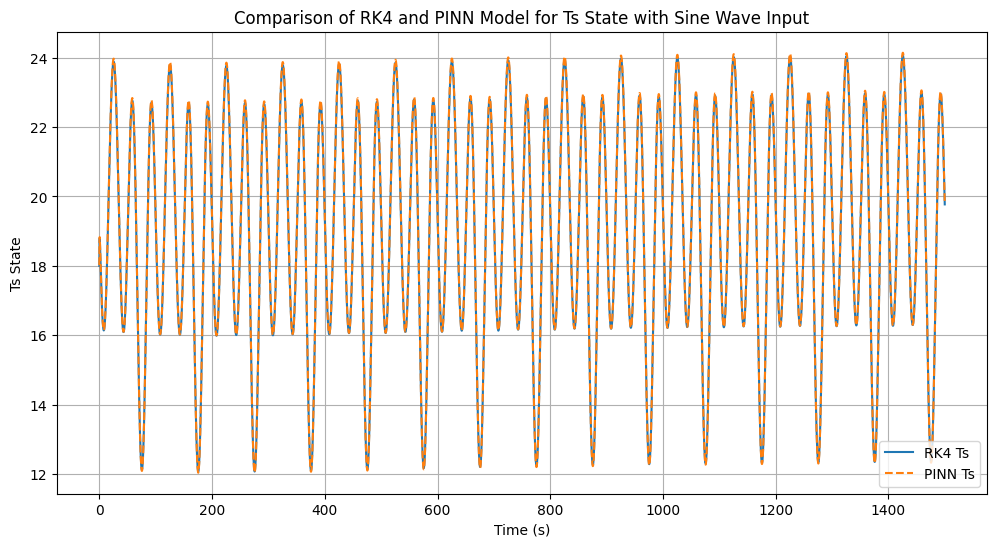

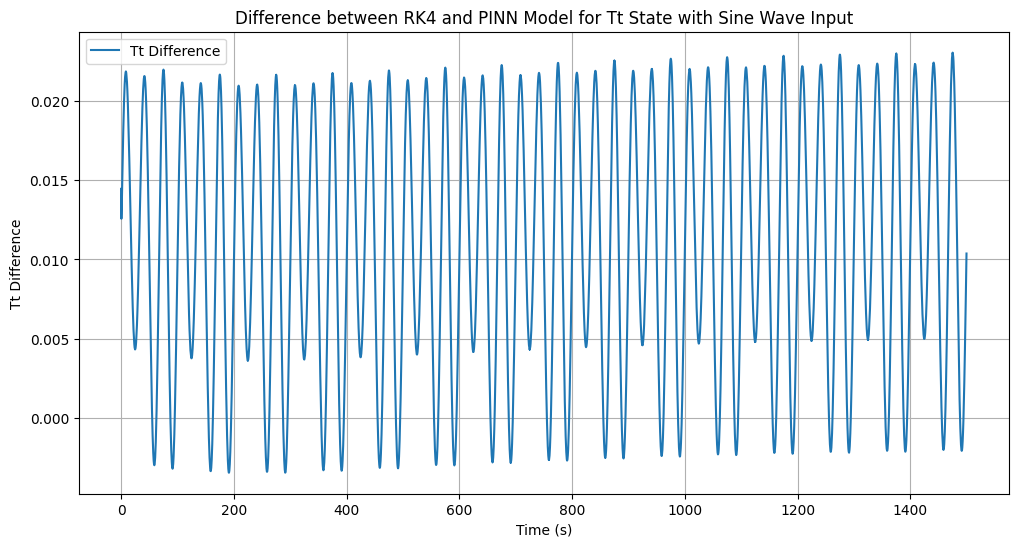

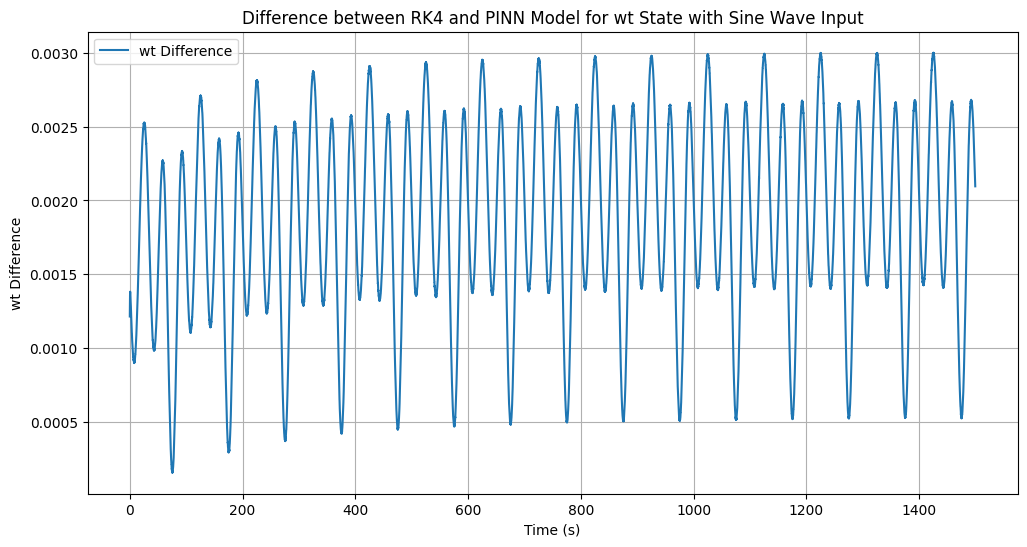

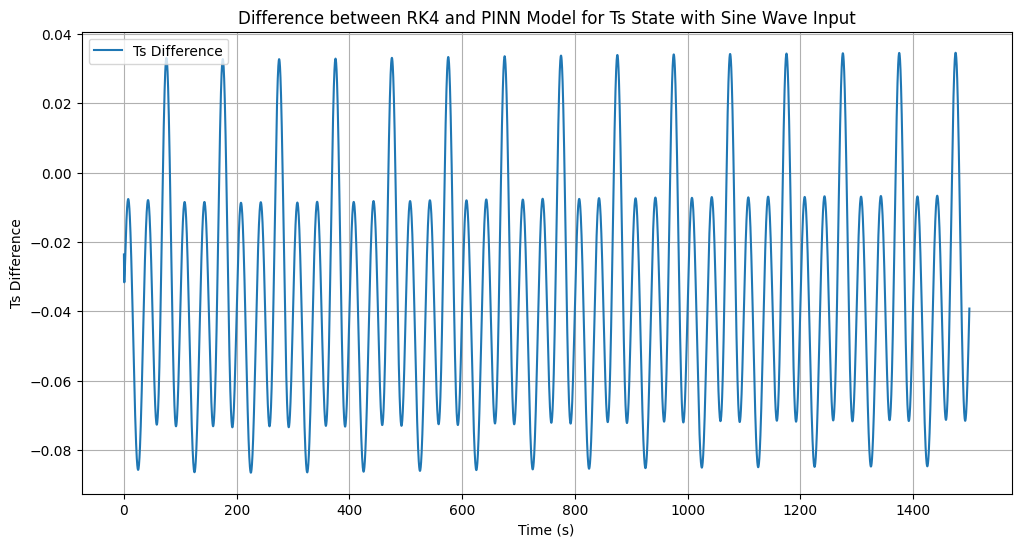

In [14]:
import numpy as np
import pandas as pd
import torch
from model import get_model
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Parameters (unchanged)
w0 = 8.2
ws = 8
Cpa = 1000
Cpw = 4180
hw = 800 * 1000
hfg = 2500 * 1000
rho_a = 1.18
rho_w = 1000
Vt = 400
Vc = 1
fa_dot = 2.6
fw_dot = 0.9 / 1000
T0 = 32
dTc = 6
M_dot0 = 0.000115
Q_dot0 = 20 * 1000

# Derived parameters (unchanged)
alpha1 = 1 / Vt
alpha2 = 1 / (rho_a * Vt)
alpha3 = 1 / Vc
beta1 = hfg / (Cpa * Vt)
beta2 = (rho_w * Cpw * dTc) / (rho_a * Cpa * Vc)
gamma1 = 1 / (rho_a * Cpa * Vt)
gamma2 = hw / (Cpa * Vc)

# Nonlinear system function (unchanged)
def nonlinear_system(t, x, u):
    Tt, wt, Ts = x
    fa_dot, fw_dot, u3 = u

    dTt = (1 / (rho_a * Cpa * Vt)) * (Q_dot0 - hfg * M_dot0) + \
          ((fa_dot * hfg) / (1000 * Cpa * Vt)) * (wt - ws) - (fa_dot / Vt) * (Tt - Ts)

    dwt = 1000 * (M_dot0 / (rho_a * Vt)) - (fa_dot / Vt) * (wt - ws) + u3

    dTs = (fa_dot / Vc) * (Tt - Ts) + \
          (0.25 * fa_dot / Vc) * (T0 - Tt) - \
          (fa_dot * hw / (1000 * Cpa * Vc)) * (0.25 * w0 + 0.75 * wt - ws) - \
          (fw_dot * rho_w * Cpw * dTc) / (rho_a * Cpa * Vc)

    return np.array([dTt, dwt, dTs])

# RK4 step function (unchanged)
def rk4_step(f, t, x, u, dt):
    k1 = f(t, x, u)
    k2 = f(t + dt / 2, x + dt * k1 / 2, u)
    k3 = f(t + dt / 2, x + dt * k2 / 2, u)
    k4 = f(t + dt, x + dt * k3, u)
    return x + dt * (k1 + 2 * k2 + 2 * k3 + k4) / 6

# Open-loop simulation (unchanged)
def run_open_loop_simulation():
    dt_rk4 = 0.1
    simulation_time = 1500.0
    n_steps = int(simulation_time / dt_rk4)
    initial_state = np.array([26, 8, 18])
    states = np.zeros((n_steps, 3), dtype=np.float32)
    states[0] = initial_state
    time = np.arange(n_steps) * dt_rk4

    # Control inputs as a sine wave for fa_dot
    control_inputs = np.zeros((n_steps, 3))
    for t in range(n_steps):
        # Sine wave for fa_dot: amplitude 0.5, frequency 0.01 Hz, centered around 2.6
        fa_dot_t = 2.6 + 0.5 * np.sin(2 * np.pi * 0.01 * time[t])
        fw_dot_t = 0.001 + .0005*np.sin(3 * np.pi * 0.02 * time[t])
        u3_t = 0.001 + .0005*np.sin(4 * np.pi * 0.6 * time[t])
        control_inputs[t] = [fa_dot_t, fw_dot_t, u3_t]

    # Simulation loop with time-varying control inputs
    for t in range(1, n_steps):
        states[t] = rk4_step(nonlinear_system, t * dt_rk4, states[t - 1], control_inputs[t], dt_rk4)

    return pd.DataFrame({
        'Time': time,
        'Tt': states[:, 0],
        'wt': states[:, 1],
        'Ts': states[:, 2]
    })

# Updated compare_with_PINN function with sine wave control inputs
def compare_with_PINN(results):
    model = get_model("lstm", {
        'input_dim': 6, 'hidden_dim': 256,
        'layer_dim': 12, 'output_dim': 3
    })
    model.load_state_dict(torch.load("PINN_STZ_colab.pth", map_location=torch.device('cpu'), weights_only=True))
    model.to(device)
    model.eval()

    # Prepare data for PINN model
    inputs = results[['Tt', 'wt', 'Ts']].values[:-1]
    time = results['Time'].values[:-1]

    # Generate sine wave control inputs matching the simulation
    control_inputs = np.zeros((len(inputs), 3))
    for t in range(len(inputs)):
        fa_dot_t = 2.6 + 0.5 * np.sin(2 * np.pi * 0.01 * time[t])  # Same sine wave as in simulation
        control_inputs[t] = [fa_dot_t, fw_dot, 0.0]  # fw_dot and u3 remain constant

    # Model Test Plot
    x_test = torch.FloatTensor(np.hstack((inputs, control_inputs))).to(device)
    yt = model(x_test).cpu().detach().numpy()

    return yt

if __name__ == "__main__":
    results = run_open_loop_simulation()
    pinn_results = compare_with_PINN(results)

    time = results['Time'][:len(pinn_results)]

    # Plotting (unchanged)
    plt.figure(figsize=(12, 6))
    plt.plot(time, results['Tt'][:len(pinn_results)], label='RK4 Tt')
    plt.plot(time, pinn_results[:, 0], label='PINN Tt', linestyle='--')
    plt.xlabel('Time (s)')
    plt.ylabel('Tt State')
    plt.title('Comparison of RK4 and PINN Model for Tt State with Sine Wave Input')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(time, results['wt'][:len(pinn_results)], label='RK4 wt')
    plt.plot(time, pinn_results[:, 1], label='PINN wt', linestyle='--')
    plt.xlabel('Time (s)')
    plt.ylabel('wt State')
    plt.title('Comparison of RK4 and PINN Model for wt State with Sine Wave Input')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(time, results['Ts'][:len(pinn_results)], label='RK4 Ts')
    plt.plot(time, pinn_results[:, 2], label='PINN Ts', linestyle='--')
    plt.xlabel('Time (s)')
    plt.ylabel('Ts State')
    plt.title('Comparison of RK4 and PINN Model for Ts State with Sine Wave Input')
    plt.legend()
    plt.grid()
    plt.show()

    # Differences (unchanged)
    differences_Tt = results['Tt'][:len(pinn_results)] - pinn_results[:, 0]
    plt.figure(figsize=(12, 6))
    plt.plot(time, differences_Tt, label='Tt Difference')
    plt.xlabel('Time (s)')
    plt.ylabel('Tt Difference')
    plt.title('Difference between RK4 and PINN Model for Tt State with Sine Wave Input')
    plt.legend()
    plt.grid()
    plt.show()

    differences_wt = results['wt'][:len(pinn_results)] - pinn_results[:, 1]
    plt.figure(figsize=(12, 6))
    plt.plot(time, differences_wt, label='wt Difference')
    plt.xlabel('Time (s)')
    plt.ylabel('wt Difference')
    plt.title('Difference between RK4 and PINN Model for wt State with Sine Wave Input')
    plt.legend()
    plt.grid()
    plt.show()

    differences_Ts = results['Ts'][:len(pinn_results)] - pinn_results[:, 2]
    plt.figure(figsize=(12, 6))
    plt.plot(time, differences_Ts, label='Ts Difference')
    plt.xlabel('Time (s)')
    plt.ylabel('Ts Difference')
    plt.title('Difference between RK4 and PINN Model for Ts State with Sine Wave Input')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# System parameters
w0 = 8.2  # kg/kg, initial humidity ratio
ws = 8.0  # kg/kg, supply air humidity ratio
Cpa = 1000  # J/(kg·K)
Cpw = 4180  # J/(kg·K)
hw = 800000  # J/kg
hfg = 2500000  # J/kg
rho_a = 1.18  # kg/m³
rho_w = 1000  # kg/m³
Vt = 400  # m³
Vc = 1  # m³
T0 = 32  # °C
dTc = 6  # K
M_dot0 = 0.000115  # kg/s
Q_dot0 = 20000  # W


def generate_setpoint_mpc(t_now):
    """Dynamic reference generator for all three states"""
    if t_now < 500:
        Tt_ref = 23 + 1.5 * np.sin(0.05 * t_now)
        wt_ref = 8 + 1 * np.sin(0.025 * t_now)
        Ts_ref = 18
    else:
        step_index = int((t_now - 500) // 200)
        Tt_ref = 23 + (step_index % 4) * 0.5
        wt_ref = 8 + (step_index % 4) * .5
        Ts_ref = 18
    return np.array([Tt_ref, wt_ref, Ts_ref])


def system_dynamics(t, x, u):
    """True system dynamics for RK4 simulation"""
    Tt, wt, Ts = x
    fa_dot, fw_dot, u3 = u

    # Differential equations
    dTt = (1 / (rho_a * Cpa * Vt)) * (Q_dot0 - hfg * M_dot0) + \
          ((fa_dot * hfg) / (1000 * Cpa * Vt)) * (wt - ws) - (fa_dot / Vt) * (Tt - Ts)

    dwt = 1000 * (M_dot0 / (rho_a * Vt)) - (fa_dot / Vt) * (wt - ws) + u3

    dTs = (fa_dot / Vc) * (Tt - Ts) + \
          (0.25 * fa_dot / Vc) * (T0 - Tt) - \
          (fa_dot * hw / (1000 * Cpa * Vc)) * (0.25 * w0 + 0.75 * wt - ws) - \
          (fw_dot * rho_w * Cpw * dTc) / (rho_a * Cpa * Vc)

    return np.array([dTt, dwt, dTs])


def rk4_step(x, u, dt):
    """4th-order Runge-Kutta integrator"""
    k1 = system_dynamics(None, x, u)
    k2 = system_dynamics(None, x + dt / 2 * k1, u)
    k3 = system_dynamics(None, x + dt / 2 * k2, u)
    k4 = system_dynamics(None, x + dt * k3, u)
    return x + dt * (k1 + 2 * k2 + 2 * k3 + k4) / 6


def run_mpc_simulation():
    # Timing parameters
    dt_rk4 = 0.1  # 100Hz simulation
    dt_mpc = 0.2  # 5Hz control updates
    total_time = 350  # 10 minutes simulation
    n_steps = int(total_time / dt_rk4)
    mpc_interval = int(dt_mpc / dt_rk4)

    # Initialize system
    # Model initialization with checks
    model = get_model("lstm", {
        'input_dim': 6, 'hidden_dim': 256,
        'layer_dim': 12, 'output_dim': 3
    })
    model.load_state_dict(torch.load("PINN_STZ_colab.pth", map_location=device))
    model.eval()

    model.eval()

    # Configure bounds and weights
    bounds = {
        'control': {
            'fa_dot': (0.1, 5.0),
            'fw_dot': (0.0, 0.003),
            'u3': (-1e-2, 1e-2)
        },
        'state': {
            'Tt': (16.0, 32.0),
            'wt': (6.5, 9.5),
            'Ts': (10.0, 26.0)
        }
    }

    # Weight matrices with enhanced tracking emphasis
    W = np.diag([100, 100, 1])  # 100x higher weight for Tt/wt tracking
    R = np.diag([1, 1, 5])  # Reduced control effort penalty (softer constraints)

    # Initialize states and controls
    current_state = np.array([23.0, 8.0, 18.0])  # Initial condition
    states = np.zeros((n_steps, 3))
    controls = np.zeros((n_steps, 3))
    states[0] = current_state
    current_control = np.array([2.0, 0.001, 0.0])

    # Main simulation loop
    next_mpc_step = mpc_interval
    for t in range(1, n_steps):
        current_time = t * dt_rk4
        current_ref = generate_setpoint_mpc(current_time)

        # MPC control update
        if t >= next_mpc_step:
            try:
                current_control, pred, _ = cost_fun_mimo(
                    current_states=states[t - 1],
                    prev_controls=current_control,
                    references=current_ref,
                    bounds=bounds,
                    model=model,
                    W=W,
                    R=R,  # Added control effort weighting matrix
                    lambda_tracking=1,
                    lambda_terminal=0.5,
                    lambda_integral=1,
                    w_state_con=100,
                    w_control_con=100,
                    s=1e-4,
                    max_iter=200,
                    dt=dt_mpc
                )
                next_mpc_step += mpc_interval
            except Exception as e:
                print(f"MPC failure at {current_time:.1f}s: {str(e)}")

        # Apply control and simulate
        controls[t] = current_control
        states[t] = rk4_step(states[t - 1], controls[t], dt_rk4)

        # Monitoring
        if t % 100 == 0:
            print(f"Time: {current_time:.1f}s | "
                  f"Tt: {states[t, 0]:.2f}C (ref: {current_ref[0]:.2f}) | "
                  f"wt: {states[t, 1]:.5f} (ref: {current_ref[1]:.5f}) | "
                  f"Ts: {states[t, 2]:.2f}C (ref: {current_ref[2]:.2f})")

    # Compile results
    time_axis = np.arange(n_steps) * dt_rk4
    return pd.DataFrame({
        'Time': time_axis,
        'Tt_actual': states[:, 0],
        'wt_actual': states[:, 1],
        'Ts_actual': states[:, 2],
        'fa_dot': controls[:, 0],
        'fw_dot': controls[:, 1],
        'u3': controls[:, 2],
        'Tt_ref': [generate_setpoint_mpc(t)[0] for t in time_axis],
        'wt_ref': [generate_setpoint_mpc(t)[1] for t in time_axis],
        'Ts_ref': [generate_setpoint_mpc(t)[2] for t in time_axis]
    })


if __name__ == "__main__":
    results = run_mpc_simulation()
    MPCplot(results[['Tt_actual', 'wt_actual', 'Ts_actual',
                     'fa_dot', 'fw_dot', 'u3',
                     'Tt_ref', 'wt_ref', 'Ts_ref']])

<ipython-input-16-b701c634b2cd>:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("PINN_STZ_colab.pth", map_location=device))
